In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
from scipy import special, integrate
import os
import sys

sys.path.insert(0, '/work2/08811/aew492/frontera/small-scale_cross-corrs')
from illustris_sim import TNGSim
import corrfuncs
import tools
from photxspec import construct_photometric_sample, wlin_theory

### construct samples: compare results from low and high $\sigma_z$, extending the box when necessary

In [3]:
# inputs
redshift = 0.5
sim = TNGSim('TNG300-3', redshift=redshift) # initialize simulation

sigma_zs = [0.003, 0.01, 0.03, 0.1, 0.2]  # 5 redshift error bins in SPHEREx

In [4]:
# functions to extend the box
def box(gal_pos_spec, boxsize, i):
    box = gal_pos_spec.copy()
    box[:,2] += i * sim.boxsize
    return box

def append_boxes(gal_pos_spec, boxsize, n=2):
    sample = gal_pos_spec.copy()
    for i in range(n):
        oneside = box(gal_pos_spec, boxsize, i+1)
        otherside = box(gal_pos_spec, boxsize, -(i+1))
        sample = np.concatenate((sample, oneside, otherside))
    return sample

### inputs to correlation function

In [5]:
nbins = 10
thetamin = 0.001
thetamax = 4.
bins = np.logspace(np.log10(thetamin), np.log10(thetamax), nbins+1)
thetaavg = 0.5 * (bins[1:] + bins[:-1])

### low $\sigma_z$: one box

In [25]:
# take a low sigma_z
sigma_z = sigma_zs[2]
# how many boxes to add?
n = 1
sigma_z

0.03

In [26]:
# dx: redshift error in comoving units
dx = tools.get_dx(redshift, sigma_z)

# spectroscopic sample
gal_pos = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
gal_pos -= sim.boxsize / 2

# extend the box:
#  add an extra so we have > a boxsize of spectroscopic galaxies on either side of the photometric tails
gal_pos_spec = append_boxes(gal_pos, sim.boxsize, n=n+1)

# construct photometric sample
gal_pos_phot = construct_photometric_sample(gal_pos_spec, dx)

 number density for SPHEREx at z=0.5: 3.62e-03 (h/Mpc)^3 
target number of subhalos: 31186


In [27]:
# divide into 2D slices along the LOS:
nslices = (2 * n + 1) * 11
losbins = np.linspace(-(n+1/2) * sim.boxsize, (n+1/2) * sim.boxsize, nslices+1)
slicewidth = (losbins[1]-losbins[0])
slice_centers = np.array([(losbins[i].value+losbins[i+1].value)/2 for i in range(nslices)]) << dx.unit
slicewidth

<Quantity 18.63636364 Mpc / littleh>

Text(0.5, 1.0, 'Photometric and spectroscopic samples: $\\sigma_z =$0.03: dx = 102 Mpc/h')

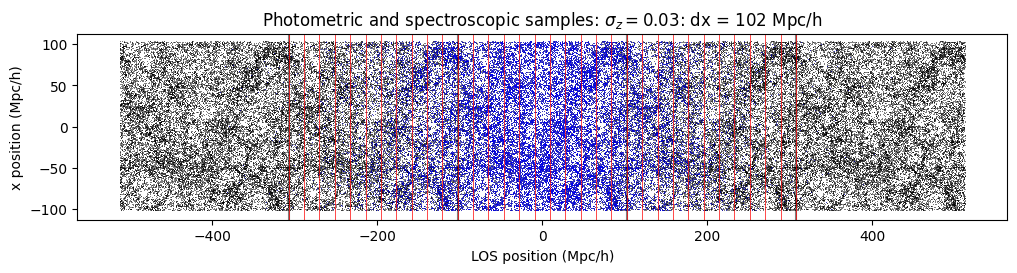

In [28]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(gal_pos_spec[:,2], gal_pos_spec[:,0], color='k', marker=',', ls='None', alpha=0.5)
ax.plot(gal_pos_phot[:,2], gal_pos_phot[:,0], color='b', marker=',', ls='None', alpha=0.5)
for i in range(n+1):
    ax.axvline(-(2*i+1)/2 * sim.boxsize.value, c='k', alpha=0.5)
    ax.axvline((2*i+1)/2 * sim.boxsize.value, c='k', alpha=0.5)
for edge in losbins:
    ax.axvline(edge.value, c='r', lw=0.5)
# ax.set_xlim(-520,520)
ax.set_xlabel('LOS position (Mpc/h)')
ax.set_ylabel('x position (Mpc/h)')
ax.set_aspect('equal')
ax.set_title(r'Photometric and spectroscopic samples: $\sigma_z =$'f'{sigma_z}: dx = {dx.value:.0f} Mpc/h')

### linear theory prediction

In [29]:
wlin = wlin_theory(gal_pos_phot, gal_pos_spec, sim, thetaavg, losbins)

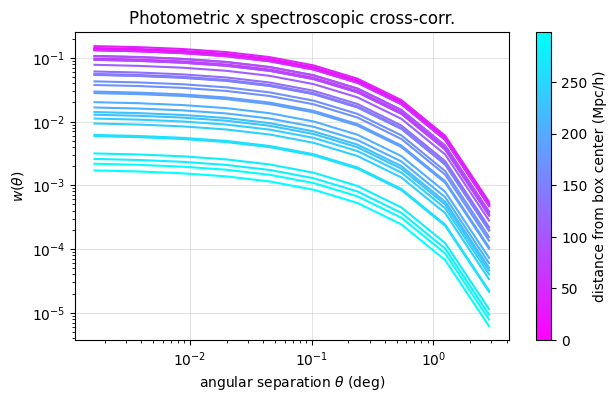

In [30]:
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers.value))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')

fig, ax = plt.subplots(figsize=(7,4))
for i, wlin_ in enumerate(wlin):
    ax.plot(thetaavg, wlin_, ls='-', c=smap.to_rgba(np.abs(slice_centers[i].value)))
ax.loglog()
ax.grid(lw=0.5, alpha=0.5)
ax.set_xlabel(r'angular separation $\theta$ (deg)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_title('Photometric x spectroscopic cross-corr.')
fig.colorbar(smap, ax=ax, label='distance from box center (Mpc/h)')

### compute cross-correlation

In [31]:
# comoving distance to the box center
chi = tools.redshift_to_comov(sim.redshift).to(dx.unit)
chi

<Quantity 1317.92319893 Mpc / littleh>

/work/08811/aew492/frontera/venv/illustris/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


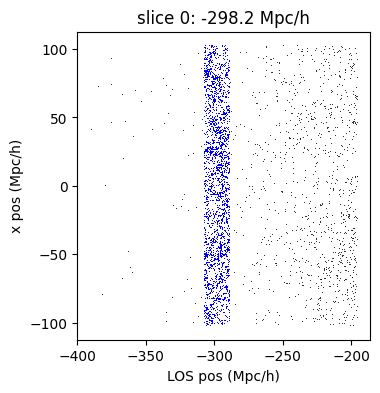

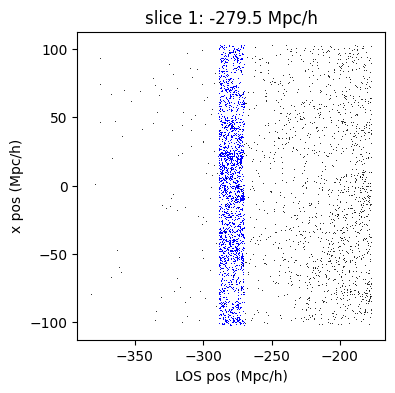

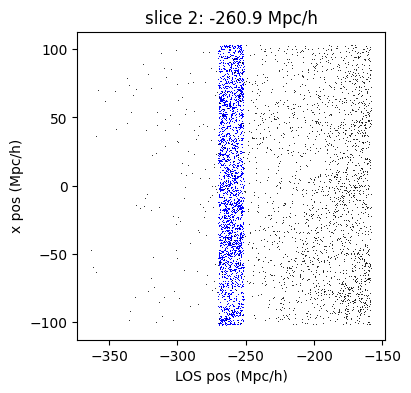

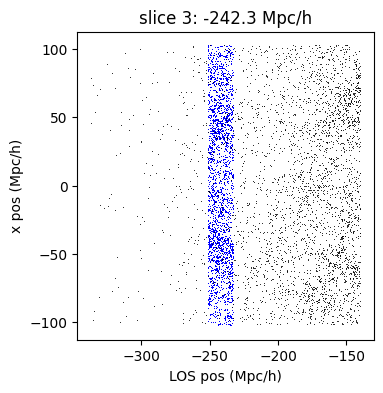

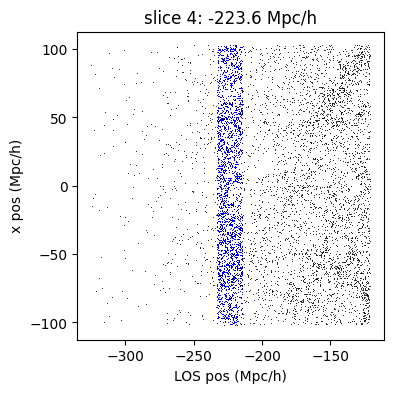

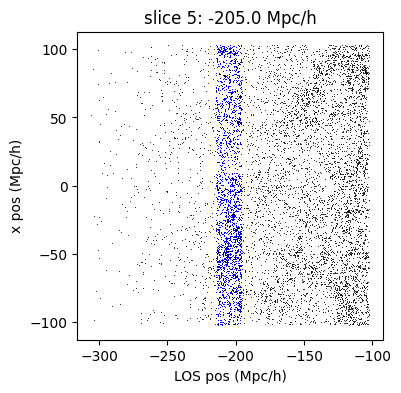

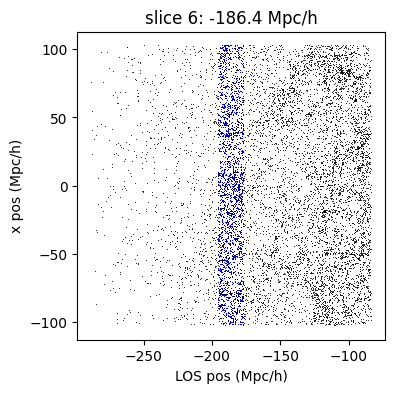

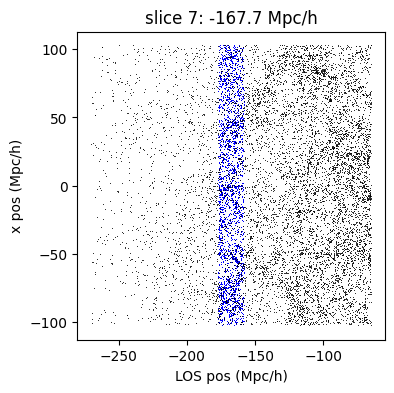

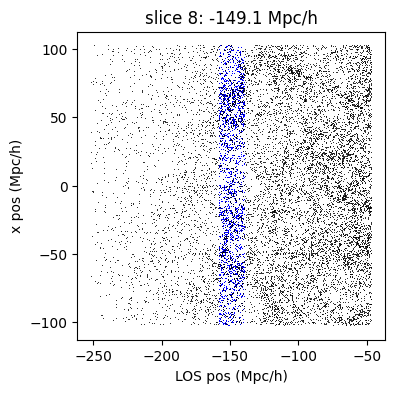

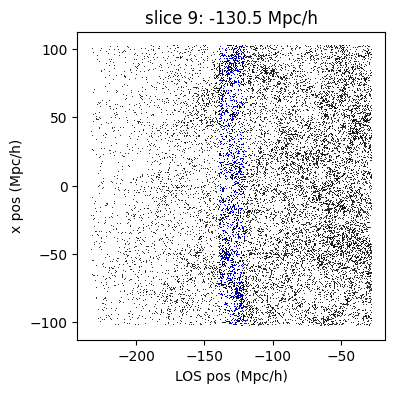

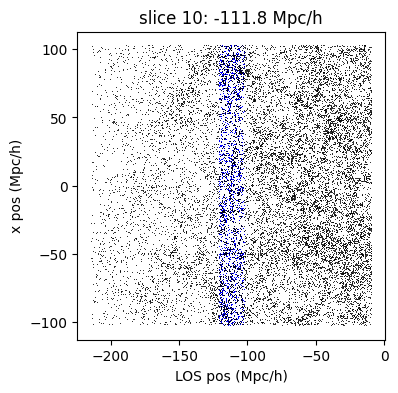

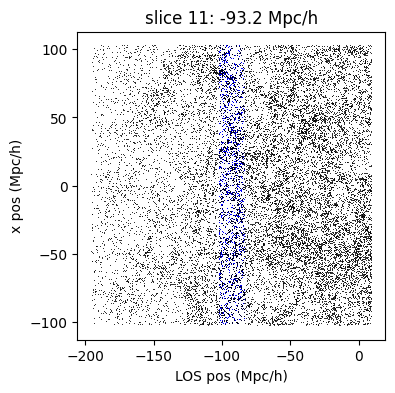

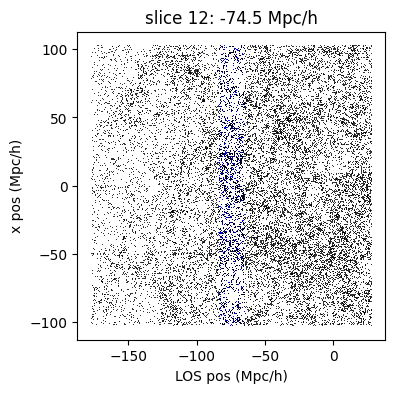

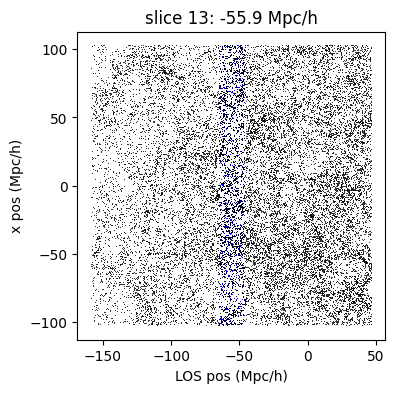

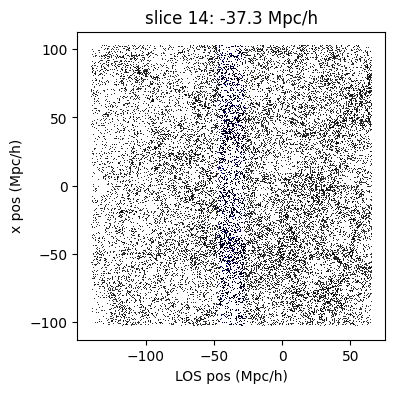

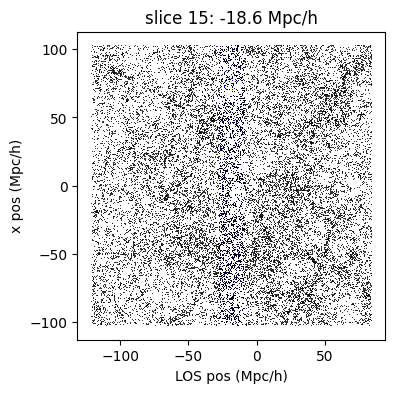

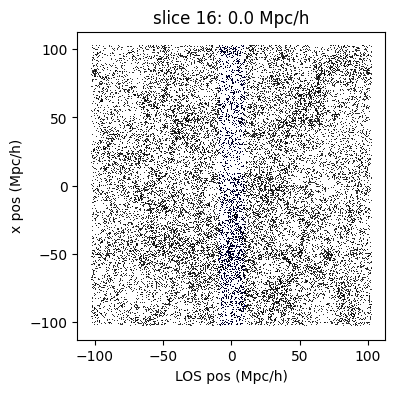

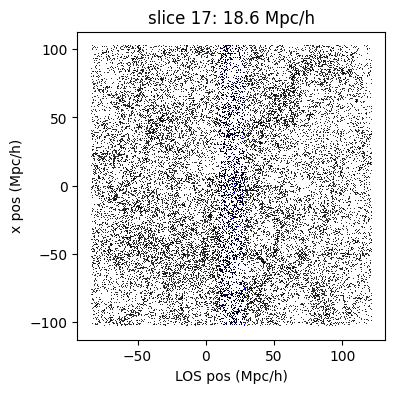

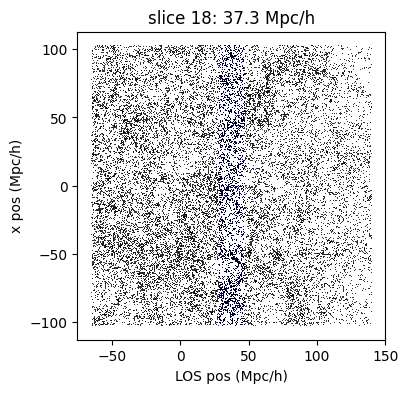

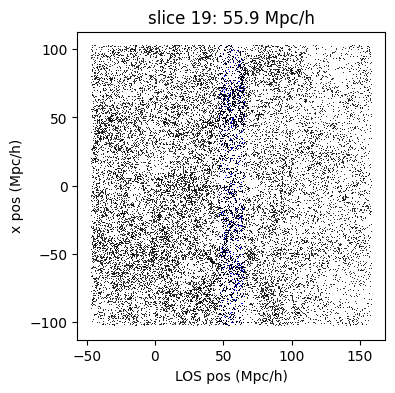

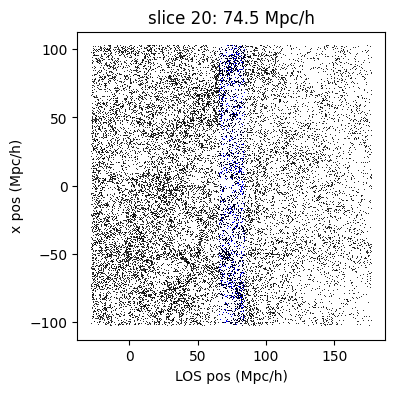

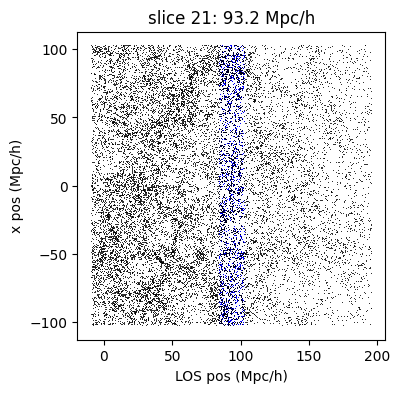

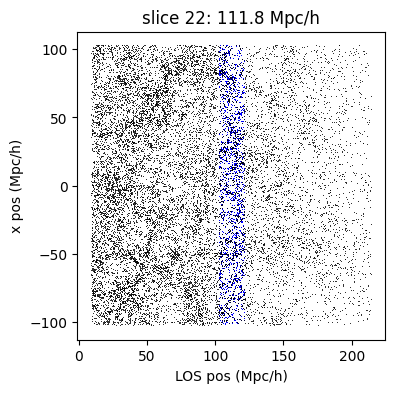

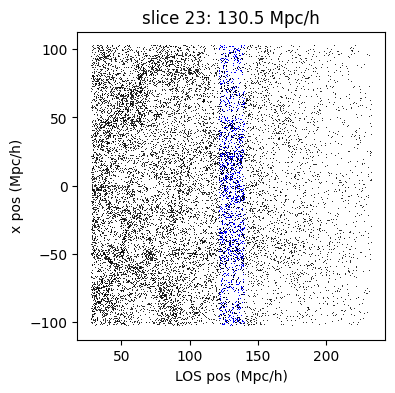

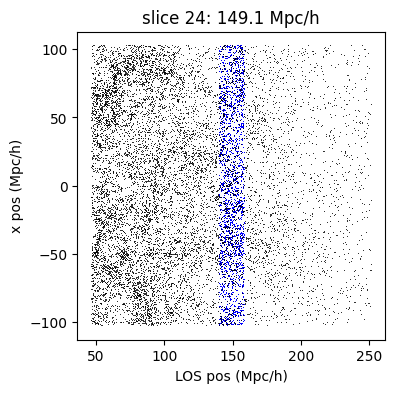

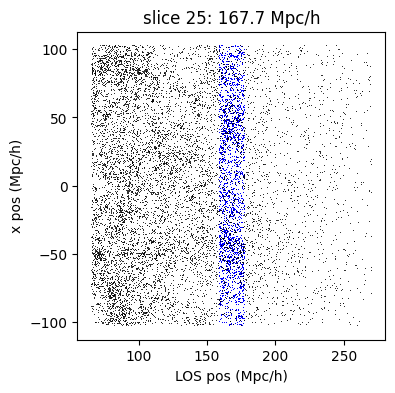

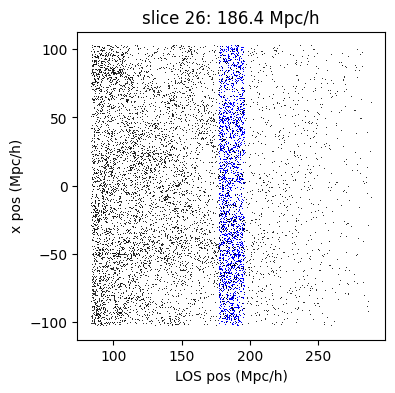

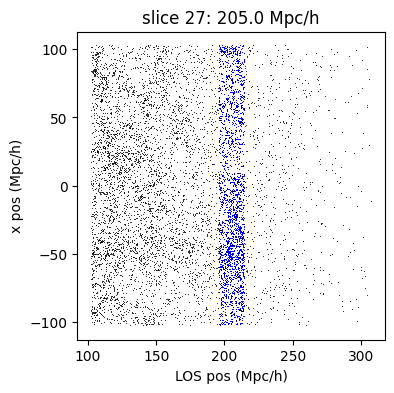

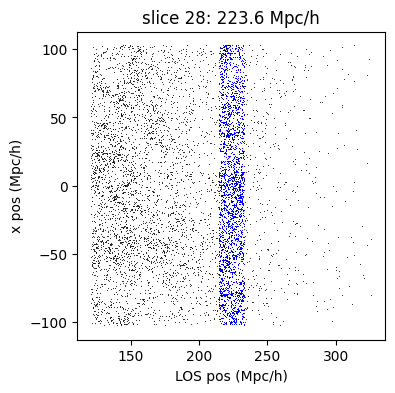

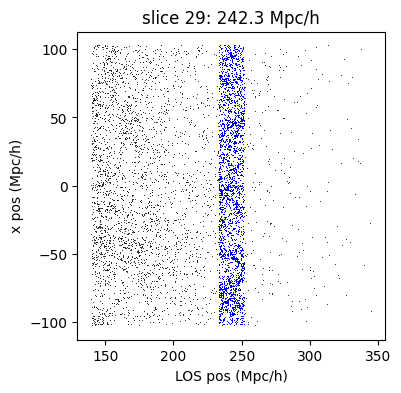

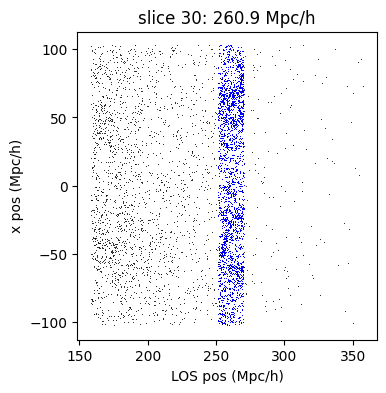

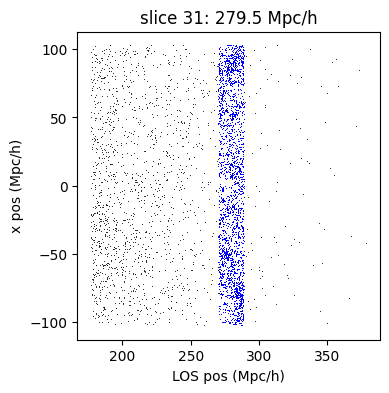

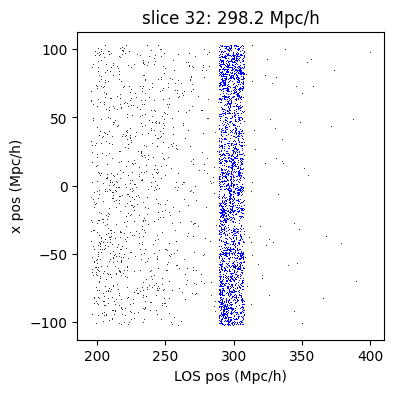

In [32]:
# compute xcorr
xcorrs = np.empty((nslices,nbins))
for i in range(nslices):
    # get indices for the galaxies in this slice and convert (x,y,z) to (RA,Dec):
    # photometric
    width = sim.boxsize
    phot_bounds = (slice_centers[i] - width/2, slice_centers[i] + width/2)
    idx_phot = (phot_bounds[0] <= gal_pos_phot[:,2]) & (gal_pos_phot[:,2] < phot_bounds[1])
    ra_phot, dec_phot = tools.get_ra_dec(gal_pos_phot[idx_phot], chi)
    # spectroscopic
    idx_spec = (losbins[i] <= gal_pos_spec[:,2]) & (gal_pos_spec[:,2] < losbins[i+1])
    ra_spec, dec_spec = tools.get_ra_dec(gal_pos_spec[idx_spec], chi)
    # random set
    ra_rand_phot = np.random.uniform(min(ra_phot.value), max(ra_phot.value), len(ra_phot)) << ra_phot.unit
    dec_rand_phot = np.random.uniform(min(dec_phot.value), max(dec_phot.value), len(dec_phot)) << ra_phot.unit
    
    # plot
    fig, ax = plt.subplots(figsize=(4,4))
    ax.plot(gal_pos_spec[idx_spec][:,2].value, gal_pos_spec[idx_spec][:,0], ls='None', marker=',', c='b')
    ax.plot(gal_pos_phot[idx_phot][:,2].value, gal_pos_phot[idx_phot][:,0], ls='None', marker=',', c='k', alpha=0.8)
    ax.set_aspect('equal')
    ax.set_xlabel('LOS pos (Mpc/h)')
    ax.set_ylabel('x pos (Mpc/h)')
    ax.set_title(f'slice {i}: {slice_centers[i].value:.1f} Mpc/h')

    thetaavg, xcorrs[i] = corrfuncs.wtheta_cross_PH(ra_phot.value, dec_phot.value, ra_spec.value, dec_spec.value,
                                      ra_rand_phot.value, dec_rand_phot.value, bins)

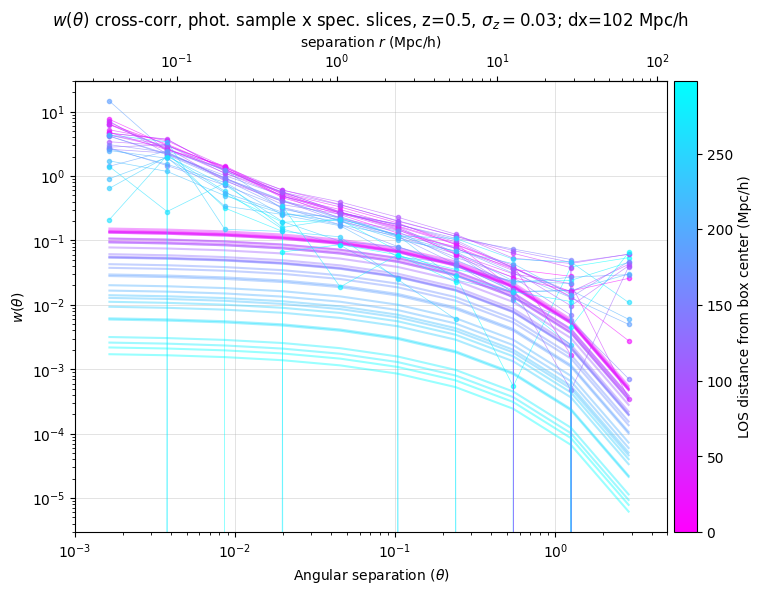

In [33]:
# color map and theta/r conversion for plotting
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers.value))
smap = mpl.cm.ScalarMappable(cmap='cool_r', norm=norm)

def theta_to_r_comov_(theta):
    return tools.theta_to_r_comov(theta, sim.redshift).value
def r_comov_to_theta_(r):
    return tools.r_comov_to_theta(r, sim.redshift).value

fig, ax = plt.subplots(figsize=(8,6))

# cross correlation in each slice for this sigma_z
for i, xcorr_slice in enumerate(xcorrs):
    c = smap.to_rgba(np.abs(slice_centers.value[i]))
    ax.plot(thetaavg, wlin[i], ls='-', alpha=0.4, c=c)
    ax.plot(thetaavg, xcorr_slice, marker='.', ls='-', lw=0.5, alpha=0.6, c=c)
secax = ax.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
secax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_xlabel(r'Angular separation ($\theta$)')
ax.set_xlim(1e-3,5.)
# ax.set_ylim(ylims[j])
ax.loglog()
ax.set_title(r'$w(\theta)$ cross-corr, phot. sample x spec. slices, 'f'z={redshift}, ' \
             r'$\sigma_z=$'+f'{sigma_z}; dx={dx.value:.0f} Mpc/h')
ax.grid(alpha=0.5, lw=0.5)
ax.set_ylabel(r'$w(\theta)$')
fig.colorbar(smap, ax=ax, pad=0.01, label='LOS distance from box center (Mpc/h)')
fig.tight_layout()